To Do List:

- remove code not in final notebook
- comment all code
- analyze modeling findings 
- FIX VALIDATION METHOD
- CONCLUSION 

# Summary

Business Problem: NYPD has a historically studied problem of needless stop-and-frisks, especially concerning BIPOC folks. The rate of stop-and-frisks that do not lead to arrests must be brought down. 


**In no way does this project advocate for more citywide arrests, but rather it advocates for NYPD to make more informed, better choices.**


Business Solution: NYPD can start an integrating machine learning to improve the timing of stops. By stopping fewer people when it’s unlikely that the stop will lead to an arrest, NYPD can work more effectively and improve the return on the investment the public has put into them. 


Data Understanding: I’ll be inspecting data going back 11 years to 2011, however stop-and-frisks were deemed unconstitutional in 2013, causing the rates and patterns of stops to change. Therefore I’ll use data from 2014 onwards to model. There will automatically be discrepancies since the pandemic in 2020 affected many time-oriented patterns of behavior and policing. 


**I am using time data and not categorical data specifically because it’s unethical to predict exactly what demographics of people will commit crimes in the future, especially with race. Conversely, there is provable seasonality of stops that do not lead to an arrest, so I will use that information instead.**


How this model is intended to be used: This model is designed to predict the next month’s rates of stops that do not lead to an arrest and be used on a daily rolling basis for police planning one month out. Designed to be retraining on a constant basis, as new data becomes available. 


Data Preparation: I prepared the data in Data Prep notebook within this repo, to clean up the DateTime columns and setting that as the index. This task was complex, due to high amounts of inconsistency in the way this data was recorded. I used string manipulation intuitively instead of back or forward-filling when I could, to preserve as much original data as possible.


Modeling: I am using SARIMA exclusively for this univariate project. SARIMA is an appropriate model for this case because Neural Networks do not lend themselves to univariate problems well, and this would not be an appropriate use of Facebook’s Prophet, which is specialized for hourly, daily or weekly seasonality where this data’s seasonality is yearly. Facebook Prophet is also not sensative enough to new data for our modeling purposes. 


Evaluation: I used my final model to forecast 4 three-month invervals into 2021, and tested that against real data, so see how close the confidence interval could capture the original data. 

Conclusion Overview: Time data alone is not enough for machine learning to help forecast when stop and frisks are less likely to lead to an arrest. In future work I would like to include more variables and different modeling approaches. 


# Imports 

In [1]:
# importing padas, numpy, matplotlib, statsmodels, statsmodels tsa, 
# datetime, and auto arima 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import json
import glob

from sklearn.metrics import mean_squared_error
from math import sqrt

from statsmodels.tsa.arima.model import ARIMA

plt.rcParams['figure.figsize'] = (12, 4)
import geopandas as gpd
import statsmodels
import statsmodels.tsa.api as tsa

from datetime import time
import pmdarima as pm
from pmdarima.arima import ADFTest


import folium

print(f'statsmodels version : {statsmodels.__version__}')
print(f' pmdarima version : {pm.__version__}')
print(f' pandas version : {pd. __version__}')
print(f' geopandas version: {gpd.__version__}')

statsmodels version : 0.13.2
 pmdarima version : 1.8.5
 pandas version : 1.1.3
 geopandas version: 0.11.1


# Functions

In [2]:
def visualize_diagnostics(preds, train):
    
    """
    DOCSTRING:
    This function expects an input of a list of predictions and a train 
    (or test/validation) set of original data. It produces two plots for visual
    diagnostics of model's predictions. 
    
    First plot: 
    We are looking to check both the range of values in the residuals, 
    and to visually inspect the residuals for decerable patterns. 
    
    
    Second plot:
    We see the standard deviation of those residuals 
    within a window of 2 weeks (starting on a two week lag) 
    which shows us how the standard deviation of those residuals grow 
    or recede over time.) 
    
    We also get two statistics: 
    1) the overall standard deviation of the residuals. 
    2) the overall variance of the residuals. 
    We want both of these statistics to be smaller with each model itteration.
    """

    fig, ax = plt.subplots()
    residuals = preds - train.squeeze()
    ax.plot(residuals.index, residuals)
    plt.title("Raw Residuals")
    
    
    fig, ax = plt.subplots()
    ax.plot(residuals.index, residuals.rolling(2).std())
    plt.title("Standard Deviation of Residuals of Previous Two Weeks")
    
    print(f'STANDARD DEVIATION OF RESIDUALS: {residuals.std()},\
    VARIANCE OF RESIDUALS: {residuals.var()}')


In [3]:
def get_mae(y_true, predictions):
    """DOCSTRING:
    takes original data as an array, and the predicted values as an array
    and returns the mean of the absolute values of errors"""
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

# taken from https://datagy.io/mae-python/

In [4]:
def last_year_visualize_preds(conf_int, train):
    
    """DOCSTRING:
    intakes a df of upper and lower confidence interval for a model. 
    outputs a visualization showing the original data in a blue line and 
    the 95% confidence interval of the algorithm as a green zone between 
    two green lines. The upper green line corresponds to an
    upper limit, the lower green line corresponds to a lower limit."""

    fig, ax = plt.subplots()

    lower = sns.lineplot(data = conf_int, 
                 y = 'lower NOT_ARRESTED_RATE',
                x = conf_int.index, color = 'g')

    upper = sns.lineplot(data = conf_int, 
                 y = 'upper NOT_ARRESTED_RATE',
                x = conf_int.index, color = 'g')

    sns.lineplot(data = train, y = "NOT_ARRESTED_RATE",
                 x = train.index, color = 'blue', ax = ax)

    plt.fill_between(train.index, 
                     conf_int['upper NOT_ARRESTED_RATE'],
                     conf_int['lower NOT_ARRESTED_RATE'], 
                    color = 'g', alpha = 0.1)
    fig.tight_layout()

In [5]:
df = pd.read_csv('stop_and_frisk_w_race.csv', index_col= "DATE_TIME", )
df = df.drop(columns = 'Unique_ID')
df.head()

# loading in the data and making the DATE_TIME the index. This data has been 
# prepared for either a time series model or a categorical model. 

SUSPECT_ARRESTED_FLAG SUSPECT_RACE_DESCRIPTION  PRECINCT
DATE_TIME                                                                
2011-01-01 00:00                     N                 E. ASIAN       102
2011-01-01 00:10                     N                    BLACK       101
2011-01-01 00:10                     N                    BLACK        73
2011-01-01 00:10                     N                    BLACK        70
2011-01-01 00:15                     N           WHITE HISPANIC        52

In [6]:
df.info()
# Looking at the data types of the columns tells us that we need to change 
# precinct into a string since it's categorical

<class 'pandas.core.frame.DataFrame'>
Index: 1545827 entries, 2011-01-01 00:00 to 2021-12-31 23:18
Data columns (total 3 columns):
 #   Column                    Non-Null Count    Dtype 
---  ------                    --------------    ----- 
 0   SUSPECT_ARRESTED_FLAG     1545827 non-null  object
 1   SUSPECT_RACE_DESCRIPTION  1545827 non-null  object
 2   PRECINCT                  1545827 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 47.2+ MB


In [46]:
ten_years_tableau_data = pd.get_dummies(df, columns = ['SUSPECT_ARRESTED_FLAG',
                                                      'SUSPECT_RACE_DESCRIPTION'],)
ten_years_tableau_data["Counts"] = 1
ten_years_tableau_data["SUSPECT_RACE_CAT"] = df['SUSPECT_RACE_DESCRIPTION']
ten_years_tableau_data['SUSPECT_ARRESTED'] = df['SUSPECT_ARRESTED_FLAG']
# ten_years_tableau_data.to_csv("ten_years_tableau_data.csv")

# EDA: inspecting totals 

PLEASE NOTE: THIS EDA IS NOT MY FULL EDA PROCESS. THE FOLLOWING TABLEAU DASHBOARDS ARE THE MAJORITY OF MY VISUALIZATION: 

2011 - 2021 
https://public.tableau.com/app/profile/louis.casanave/viz/2011-2021NYPDStopAndFriskByPrecicntRaceandOutcome/2011-2021NYPDStopAndFrisksByPrecinctRaceandOutcome?publish=yes

JUST 2021 (the target) 
https://public.tableau.com/app/profile/louis.casanave/viz/StopandFrisk2021NYPD/StopandFrisk2021DemographicOverview



## Arrested vs. Not Arrested Totals

In [38]:
df_dummied = pd.get_dummies(df, columns = ['SUSPECT_ARRESTED_FLAG', 
                                           'SUSPECT_RACE_DESCRIPTION',
                                          'PRECINCT'])
df_dummied.head()

# I'm dummying all the columns because they are all categorical and we need
# to dummy them to aggrigate the nessisary statistics and reorganize the data

In [8]:
arrested_cols = ['SUSPECT_ARRESTED_FLAG_N', 'SUSPECT_ARRESTED_FLAG_Y']
# making a list of just arrest information 

race_cols = [col for col in df_dummied.columns if 'RACE' in col]
# making a list of just the race information

precinct_cols = [col for col in df_dummied.columns if 'PRECINCT' in col]
# making a list of just the precinct information

arrested_df = df_dummied.drop(columns=[col for col in df_dummied.columns \
                                       if col not in arrested_cols])
# making arrested cols into it's own DF 

arrested_df.head()

# taking a look at just the arrested information

SUSPECT_ARRESTED_FLAG_N  SUSPECT_ARRESTED_FLAG_Y
DATE_TIME                                                         
2011-01-01 00:00                        1                        0
2011-01-01 00:10                        1                        0
2011-01-01 00:10                        1                        0
2011-01-01 00:10                        1                        0
2011-01-01 00:15                        1                        0

In [9]:
arrested_stats = pd.DataFrame(arrested_df.sum())
# summing up all the columns for raw stats 
arrested_stats.rename({0 : "Counts"}, axis = 1, inplace = True)
# Renaming the column that holds the counts of information
arrested_stats
# Taking a look at these statistics

Counts
SUSPECT_ARRESTED_FLAG_N  1425853
SUSPECT_ARRESTED_FLAG_Y   119974

### Visualizing the total arrested vs not arrested

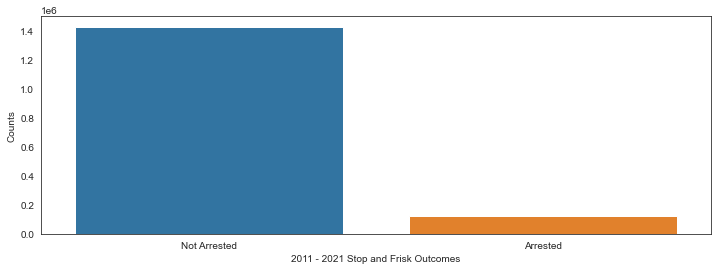

In [10]:
sns.set_style('white')
# just making sure the graphs can be seen on any background

arrested_plot = sns.barplot(x = arrested_stats.index,
                            y = 'Counts', 
                            data = arrested_stats,)
# making a barplot to show the arrested stats

arrested_plot.set_xticklabels(['Not Arrested', 'Arrested'])
arrested_plot.set_xlabel('2011 - 2021 Stop and Frisk Outcomes');
# giving the graphs titles and labels

## Arrests by Race Totals

In [11]:
arrs_by_race_df = df_dummied.drop(columns=[col for col in df_dummied.columns \
                                           if col  in precinct_cols])
# making race information it's own df and taking a look at that df
arrs_by_race_df.head()

SUSPECT_ARRESTED_FLAG_N  SUSPECT_ARRESTED_FLAG_Y  \
DATE_TIME                                                            
2011-01-01 00:00                        1                        0   
2011-01-01 00:10                        1                        0   
2011-01-01 00:10                        1                        0   
2011-01-01 00:10                        1                        0   
2011-01-01 00:15                        1                        0   

                  SUSPECT_RACE_DESCRIPTION_BLACK  \
DATE_TIME                                          
2011-01-01 00:00                               0   
2011-01-01 00:10                               1   
2011-01-01 00:10                               1   
2011-01-01 00:10                               1   
2011-01-01 00:15                               0   

                  SUSPECT_RACE_DESCRIPTION_BLACK HISPANIC  \
DATE_TIME                                                   
2011-01-01 00:00                                        0   
2011-01-01 00:10                                        0   
2011-01-01 00:10                                        0   
2011-01-01 00:10                                        0   
2011-01-01 00:15                                        0   

                  SUSPECT_RACE_DESCRIPTION_E. ASIAN  \
DATE_TIME                                             
2011-01-01 00:00                                  1   
2011-01-01 00:10                                  0   
2011-01-01 00:10                                  0   
2011-01-01 00:10                                  0   
2011-01-01 00:15                                  0   

                  SUSPECT_RACE_DESCRIPTION_NATIVE  \
DATE_TIME                                           
2011-01-01 00:00                                0   
2011-01-01 00:10                                0   
2011-01-01 00:10                                0   
2011-01-01 00:10                                0   
2011-01-01 00:15                                0   

                  SUSPECT_RACE_DESCRIPTION_OTHER  \
DATE_TIME                                          
2011-01-01 00:00                               0   
2011-01-01 00:10                               0   
2011-01-01 00:10                               0   
2011-01-01 00:10                               0   
2011-01-01 00:15                               0   

                  SUSPECT_RACE_DESCRIPTION_UNKNOWN  \
DATE_TIME                                            
2011-01-01 00:00                                 0   
2011-01-01 00:10                                 0   
2011-01-01 00:10                                 0   
2011-01-01 00:10                                 0   
2011-01-01 00:15                                 0   

                  SUSPECT_RACE_DESCRIPTION_W. ASIAN  \
DATE_TIME                                             
2011-01-01 00:00                                  0   
2011-01-01 00:10                                  0   
2011-01-01 00:10                                  0   
2011-01-01 00:10                                  0   
2011-01-01 00:15                                  0   

                  SUSPECT_RACE_DESCRIPTION_WHITE  \
DATE_TIME                                          
2011-01-01 00:00                               0   
2011-01-01 00:10                               0   
2011-01-01 00:10                               0   
2011-01-01 00:10                               0   
2011-01-01 00:15                               0   

                  SUSPECT_RACE_DESCRIPTION_WHITE HISPANIC  
DATE_TIME                                                  
2011-01-01 00:00                                        0  
2011-01-01 00:10                                        0  
2011-01-01 00:10                                        0  
2011-01-01 00:10                                        0  
2011-01-01 00:15                                        1

In [12]:
arrs_by_race_df.rename({
          'SUSPECT_RACE_DESCRIPTION_BLACK' : 'BLACK',
          'SUSPECT_RACE_DESCRIPTION_BLACK HISPANIC' : 'BLACK_HISPANIC',
          'SUSPECT_RACE_DESCRIPTION_E. ASIAN' : 'E._ASIAN', 
          'SUSPECT_RACE_DESCRIPTION_NATIVE' : 'NATIVE',
          'SUSPECT_RACE_DESCRIPTION_OTHER': 'OTHER',
          'SUSPECT_RACE_DESCRIPTION_UNKNOWN' : 'UNKNOWN',
          'SUSPECT_RACE_DESCRIPTION_W. ASIAN' : 'W._ASIAN',
          'SUSPECT_RACE_DESCRIPTION_WHITE' : 'WHITE',
          'SUSPECT_RACE_DESCRIPTION_WHITE HISPANIC' : 'WHITE_HISPANIC'},
         axis = 1, inplace = True)

# making our information more readable by renaming race columns

arrs_by_race_df.head()

SUSPECT_ARRESTED_FLAG_N  SUSPECT_ARRESTED_FLAG_Y  BLACK  \
DATE_TIME                                                                   
2011-01-01 00:00                        1                        0      0   
2011-01-01 00:10                        1                        0      1   
2011-01-01 00:10                        1                        0      1   
2011-01-01 00:10                        1                        0      1   
2011-01-01 00:15                        1                        0      0   

                  BLACK_HISPANIC  E._ASIAN  NATIVE  OTHER  UNKNOWN  W._ASIAN  \
DATE_TIME                                                                      
2011-01-01 00:00               0         1       0      0        0         0   
2011-01-01 00:10               0         0       0      0        0         0   
2011-01-01 00:10               0         0       0      0        0         0   
2011-01-01 00:10               0         0       0      0        0         0   
2011-01-01 00:15               0         0       0      0        0         0   

                  WHITE  WHITE_HISPANIC  
DATE_TIME                                
2011-01-01 00:00      0               0  
2011-01-01 00:10      0               0  
2011-01-01 00:10      0               0  
2011-01-01 00:10      0               0  
2011-01-01 00:15      0               1

In [16]:
outcomes = ['SUSPECT_ARRESTED_FLAG_N', 'SUSPECT_ARRESTED_FLAG_Y']
# making a list of outcomes to use 

arrs_by_race = arrs_by_race_df.pivot_table(index = outcomes, aggfunc = 'sum')
# making a pivot table to show the totals of each outcome by race 

arrs_by_race = arrs_by_race.reset_index(drop= True).transpose()
# flipping that table on it's side for easier readability 

arrs_by_race.rename({0 : 'ARRESTED', 1 : 'NOT ARRESTED'}, axis = 1, 
                    inplace = True)
# renaming outcomes for better readability 

arrs_by_race.sort_values(by  = 'NOT ARRESTED', inplace = True)
# sorting races by the target, the not arrested statistic 

arrs_by_race = arrs_by_race.astype(int)
# casing everything as an integer instead of a float for readability 

arrs_by_race.style.bar()
# taking a look at the distributions and statistics

In [ ]:
### Visualizing 

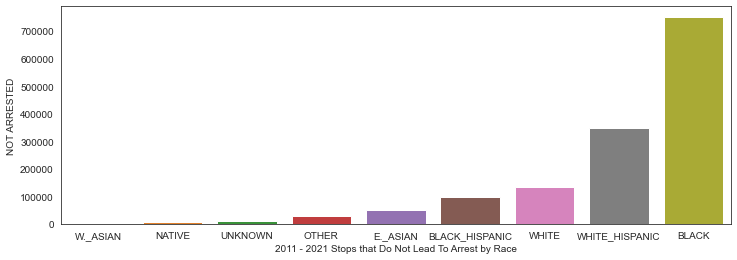

In [17]:
arrs_by_race_plot = sns.barplot(x = arrs_by_race.index, 
                                y = 'NOT ARRESTED', 
                                data = arrs_by_race)
# making a bar plot to look at how many stops did not lead to an arrest

arrs_by_race_plot.set_xlabel('2011 - 2021 Stops that Do Not Lead To Arrest by Race');
# setting the label on the graph

## Arrest by Precinct Totals

In [18]:
arrs_by_precinct_df = df_dummied.drop(columns=[col for col in \
                                               df_dummied.columns if col \
                                               in race_cols])
# making arrests by precinct it's own DF 

arrs_by_precinct_df.head()
# taking a look at the data

SUSPECT_ARRESTED_FLAG_N  SUSPECT_ARRESTED_FLAG_Y  \
DATE_TIME                                                            
2011-01-01 00:00                        1                        0   
2011-01-01 00:10                        1                        0   
2011-01-01 00:10                        1                        0   
2011-01-01 00:10                        1                        0   
2011-01-01 00:15                        1                        0   

                  PRECINCT_0  PRECINCT_1  PRECINCT_5  PRECINCT_6  PRECINCT_7  \
DATE_TIME                                                                      
2011-01-01 00:00           0           0           0           0           0   
2011-01-01 00:10           0           0           0           0           0   
2011-01-01 00:10           0           0           0           0           0   
2011-01-01 00:10           0           0           0           0           0   
2011-01-01 00:15           0           0           0           0           0   

                  PRECINCT_9  PRECINCT_10  PRECINCT_13  ...  PRECINCT_110  \
DATE_TIME                                               ...                 
2011-01-01 00:00           0            0            0  ...             0   
2011-01-01 00:10           0            0            0  ...             0   
2011-01-01 00:10           0            0            0  ...             0   
2011-01-01 00:10           0            0            0  ...             0   
2011-01-01 00:15           0            0            0  ...             0   

                  PRECINCT_111  PRECINCT_112  PRECINCT_113  PRECINCT_114  \
DATE_TIME                                                                  
2011-01-01 00:00             0             0             0             0   
2011-01-01 00:10             0             0             0             0   
2011-01-01 00:10             0             0             0             0   
2011-01-01 00:10             0             0             0             0   
2011-01-01 00:15             0             0             0             0   

                  PRECINCT_115  PRECINCT_120  PRECINCT_121  PRECINCT_122  \
DATE_TIME                                                                  
2011-01-01 00:00             0             0             0             0   
2011-01-01 00:10             0             0             0             0   
2011-01-01 00:10             0             0             0             0   
2011-01-01 00:10             0             0             0             0   
2011-01-01 00:15             0             0             0             0   

                  PRECINCT_123  
DATE_TIME                       
2011-01-01 00:00             0  
2011-01-01 00:10             0  
2011-01-01 00:10             0  
2011-01-01 00:10             0  
2011-01-01 00:15             0  

[5 rows x 80 columns]

In [22]:
arrs_by_precinct = arrs_by_precinct_df.pivot_table(index = outcomes, aggfunc = 'sum')
# making a pivot table to look at the outcomes by race with all cases totaled 

arrs_by_precinct = arrs_by_precinct.reset_index(drop= True).transpose()
# resetting the index and flipping the pivot table over for readability 

arrs_by_precinct.rename({0 : 'ARRESTED', 1 : 'NOT ARRESTED'}, axis = 1, 
                    inplace = True)
# renaming the new columns for readability 

arrs_by_precinct = arrs_by_precinct.astype(int)
# casing everything as an integer instead of a float for readability 

arrs_by_precinct.head()
# taking a look at the pivot table (note that I am keeping precint_0 as it was 
# used in data preperation to denote an unknown precinct, rather than dropping 
# values)

ARRESTED  NOT ARRESTED
PRECINCT_0         113           319
PRECINCT_1         704          7857
PRECINCT_10       1010          6442
PRECINCT_100       912         10891
PRECINCT_101      1486         28719

In [23]:
arrs_by_precinct['DIFFERENCE'] = arrs_by_precinct['NOT ARRESTED'] - arrs_by_precinct['ARRESTED']
# making a column to keep track of the differnce between stops that lead to an 
# arrest and stops that do not lead to an arrest

arrs_by_precinct.sort_values(by = 'DIFFERENCE', inplace = True)
# sorting the data by that difference 

arrs_by_precinct.astype(int).style.bar()
# recasting the data as an int for readability and looking at the distributions
# and statistics

In [24]:
arrs_by_precinct.reset_index(inplace = True)

# setting the index for visualization 

## visualizing outcome disparities by precinct 

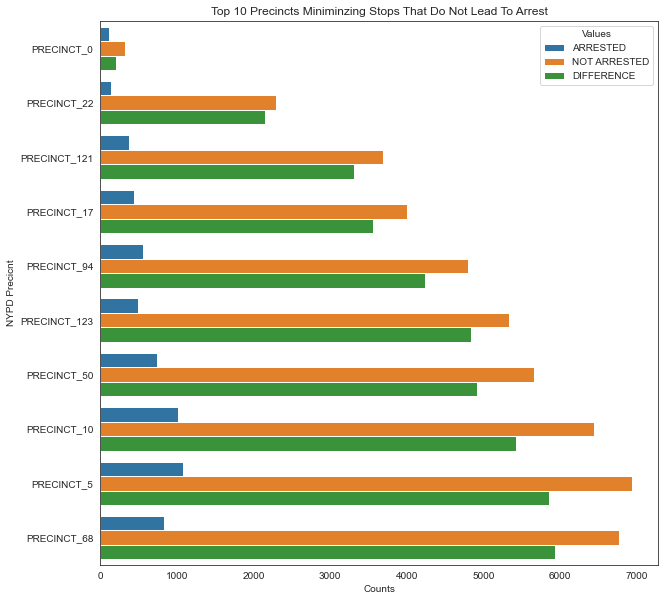

In [31]:
plt.figure(figsize=(10, 10))
# resetting the size of the plot

sns.barplot(data = arrs_by_precinct.head(10).melt(id_vars='index',
                                         value_name='Counts', 
                                         var_name='Values'),
            y='index', x='Counts', hue='Values')
# making a plot to show the precicnts where the difference is lowest aka the 
# police are doing the best job determening who to stop 

plt.title("Top 10 Precincts Miniminzing Stops That Do Not Lead To Arrest")
plt.ylabel("NYPD Precicnt");
# setting labels and titles

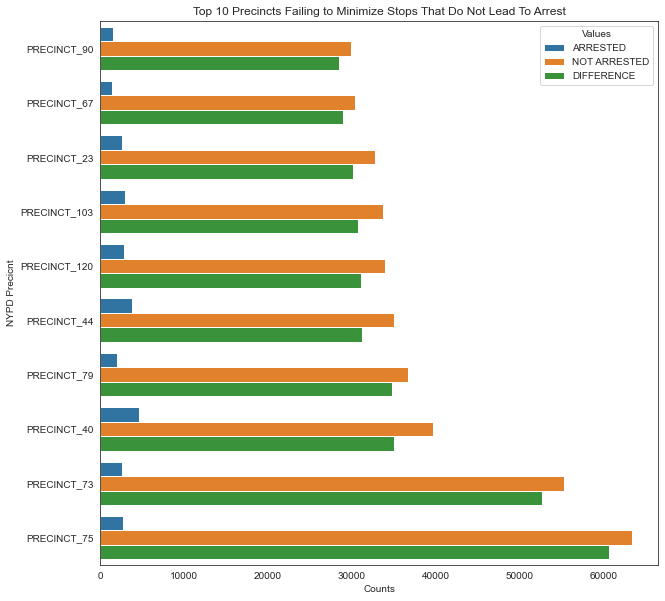

In [32]:
plt.figure(figsize=(10, 10))
# resetting the size of the plot

sns.barplot(data = arrs_by_precinct.tail(10).melt(id_vars='index',
                                         value_name='Counts', 
                                         var_name='Values'),
            y='index', x='Counts', hue='Values')
# making a plot to show the precicnts where the difference is lowest aka the 
# police are doing the best job determening who to stop 

plt.title("Top 10 Precincts Failing to Minimize Stops That Do Not Lead To Arrest")
plt.ylabel("NYPD Precicnt");
# setting labels and titles

Observations: In Both Plots these bars look very similar, it's just a matter of scale. 

## Arrests by Precinct On a Map

In [33]:
arrs_by_precinct_map = arrs_by_precinct.copy()
# making a copy of arrs_by_precicnt to use for mapping 

vals = [x.split('_')[1] for x in arrs_by_precinct_map['index']]
# seperating "precicnt" out of the precicnts index

arrs_by_precinct_map['index'] = vals
# replacing the index with the new list of values 

arrs_by_precinct_map.drop(0, inplace = True)
# dropping precinct 0 or unknown as it will mess with the mapping 

arrs_by_precinct_map
# taking a look at the data

index  ARRESTED  NOT ARRESTED  DIFFERENCE
1     22       145          2294        2149
2    121       380          3692        3312
3     17       437          4002        3565
4     94       555          4795        4240
5    123       498          5338        4840
..   ...       ...           ...         ...
73    44      3752         35000       31248
74    79      1942         36667       34725
75    40      4626         39603       34977
76    73      2545         55248       52703
77    75      2668         63346       60678

[77 rows x 4 columns]

In [34]:
arrs_by_precinct_map['index'] = arrs_by_precinct_map['index'].astype(int)
# casting the index to be integers so the geojsn file will recognize it 

arrs_by_precinct_map['DIFFERENCE'] = arrs_by_precinct_map['DIFFERENCE'].astype(int)
# doing the same thing with the differnce just to be sure 

arrs_by_precinct_map.info()
# triple checking data types before we visualize 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 1 to 77
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   index         77 non-null     int64
 1   ARRESTED      77 non-null     int64
 2   NOT ARRESTED  77 non-null     int64
 3   DIFFERENCE    77 non-null     int64
dtypes: int64(4)
memory usage: 3.0 KB


### Making a choropleth that uses the difference as the shading 

to make a visualization using folium, I'll need a geojason file for the precincts, found here

citation: https://www1.nyc.gov/site/planning/data-maps/open-data/districts-download-metadata.page

In [36]:
with open ('tableau_data/precincts.json') as f:
    json_data = json.load(f)
    # open the geojsn file and nameing it json_data

In [37]:
my_thresh = arrs_by_precinct_map['NOT ARRESTED'].quantile((0, 0.25, 0.5, 
                                                           0.75, 1)).tolist()
# making the threshold of shades to represent the quartiles where most of the 
# data is 

m = folium.Map(location=[40.693943, -73.985880], default_zoom_start=10)
# making the base map of NYC 

folium.Choropleth(
    geo_data = json_data,
    name = "Sum of Stops That Did Not Lead To Arrest",
    data = arrs_by_precinct_map,
    columns = ["index", 'NOT ARRESTED'],
    key_on = "feature.properties.Precinct",
    fill_color = 'BuPu',
    fill_opacity = 0.75,
    line_opacity = 0.2,
    legend_name = "2011-2021 Sum of Stops That Do Not Lead To An Arrest",
    threshold_scale = my_thresh
).add_to(m)
# adding the choropleth to the base map

folium.LayerControl().add_to(m)
# right now this map has only one layer, but in future work it may have more

m
# showing the final map

Observations: (I will be brief as this map is static and in the future I want to come back and make this map interactive using Folium.)

Over the last ten years, stops that do not lead to arrest have been most populous in East New York and Bushwick, Flatbush, East Harlem, and the South Bronx. Stops that do lead to arrest have been most common on the west side of Manhattan and Downtown Manhattan, Bay Ridge, and the parts of Staten Island furthest away from the city. 

Most of the data skews very heavily in the upper extreme, making places where stops do lead to an arrest more common the real outliers of this data. 

# EDA: inspecting timelines

In [ ]:
df_dummied.index = pd.to_datetime(df_dummied.index)
df_dummied = df_dummied.sort_index()

## including before it was deemed unconstitutional 

In [ ]:
by_day = df_dummied['SUSPECT_ARRESTED_FLAG_N'].resample('D').sum()
by_day.plot()

In [ ]:
by_week = df_dummied['SUSPECT_ARRESTED_FLAG_N'].resample('W').sum()
by_week.plot()

In [ ]:
by_month = df_dummied['SUSPECT_ARRESTED_FLAG_N'].resample('M').sum()
by_month.plot()

In [ ]:
by_year = df_dummied['SUSPECT_ARRESTED_FLAG_N'].resample('Y').sum()
by_year.plot()

## only after it was deemed unconstitutonal 

In [ ]:
fourteen_onward = df_dummied.loc['2014':]
fourteen_onward

In [ ]:
fourteen_by_day = fourteen_onward['SUSPECT_ARRESTED_FLAG_N'].resample('D').sum()
fourteen_by_day.plot()

In [ ]:
fourteen_by_week = fourteen_onward['SUSPECT_ARRESTED_FLAG_N'].resample('W').sum()
fourteen_by_week.plot()

In [ ]:
fourteen_by_month = fourteen_onward['SUSPECT_ARRESTED_FLAG_N'].resample('M').sum()
fourteen_by_month.plot()

In [ ]:
fourteen_by_year = fourteen_onward['SUSPECT_ARRESTED_FLAG_N'].resample('Y').sum()
fourteen_by_year.plot()

## only after the new data system upgrade 

In [ ]:
eighteen_onward = df_dummied.loc['2018':]
eighteen_onward

In [ ]:
eighteen_by_day = eighteen_onward['SUSPECT_ARRESTED_FLAG_N'].resample('D').sum()
eighteen_by_day.plot()

In [ ]:
eighteen_by_week = eighteen_onward['SUSPECT_ARRESTED_FLAG_N'].resample('W').sum()
eighteen_by_week.plot()

In [ ]:
eighteen_by_month = eighteen_onward['SUSPECT_ARRESTED_FLAG_N'].resample('M').sum()
eighteen_by_month.plot()

In [ ]:
eighteen_by_year = eighteen_onward['SUSPECT_ARRESTED_FLAG_N'].resample('Y').sum()
eighteen_by_year.plot()

# Investigating stops that do lead to an arrest from 2014-onward

In [ ]:
by_month_arrested = fourteen_onward['SUSPECT_ARRESTED_FLAG_Y'].resample('M').sum()
by_month_arrested.plot()

# Getting the Not-Arrested Rate by Week 2014-onward

In [ ]:
#fourteen_onward = fourteen_onward.drop(columns = 'Unique_ID')
fourteen_onward['COUNTS'] = 1
fourteen_onward.head()

In [ ]:
fourteen_onward = fourteen_onward.resample('M').sum()
fourteen_onward['NOT_ARRESTED_RATE'] = fourteen_onward['SUSPECT_ARRESTED_FLAG_N'] / fourteen_onward['COUNTS']
fourteen_onward.head()

In [ ]:
fourteen_not_arrested = fourteen_onward.drop(columns= [col for col in fourteen_onward.columns if not col == 'NOT_ARRESTED_RATE'])

In [ ]:
fourteen_not_arrested_plot = fourteen_not_arrested.plot()

In [ ]:
fourteen_not_arrested.describe()

In [ ]:
plt.figure(figsize=(10, 10))

sns.histplot(data = fourteen_not_arrested, x = 'NOT_ARRESTED_RATE', bins= 12)

Observations: the distribution isn't a normal distribution exactly, it skews and is somewhat split.

In [ ]:
# Determine rolling statistics
roll_mean = fourteen_not_arrested.rolling(window=3, center=False).mean()
roll_std = fourteen_not_arrested.rolling(window=3, center=False).std()


In [ ]:
# Plot rolling statistics
fig = plt.figure(figsize=(12,6))
plt.plot(fourteen_not_arrested, color='blue',label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

# Dickey-Fuller Test

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n')
dftest = adfuller(fourteen_not_arrested['NOT_ARRESTED_RATE'])

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

observations: the P value is above 0.05 so we can reject the null hypothesis, this time series is not stationary and cannot be modeled by ARMA types of models. 


In [ ]:
adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(fourteen_not_arrested)  # (0.01, False)
print(f'{p_val} : {should_diff}')

In [ ]:
from pmdarima.arima.utils import ndiffs

n_adf = ndiffs(fourteen_not_arrested, test='adf')
print(n_adf)

## Decomposition 

In [ ]:
# Import and apply seasonal_decompose()
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(fourteen_not_arrested, model = "additive")

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(fourteen_not_arrested), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='green')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='purple')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='red')
plt.legend(loc='best')
plt.tight_layout()


Observations: 

- this data has an overall trend line going down (Green)
- there is repeating seasonality in this data (Purple)
- the noise in the data only accounts for about 20% of the overall rate of not-arrest,(Red) meaning that 80% of the data *is* following the trend and seasonality 

# Linear Train Test Split

In [ ]:
valid = fourteen_not_arrested.loc['2021-01-03': '2021-12-26']
valid

In [ ]:
train = fourteen_not_arrested.loc['2014': '2020']
train

In [ ]:
train.shape

In [ ]:
valid.shape

In [ ]:
# visualizing the split

fig, ax = plt.subplots()
ax.plot(train, label = 'train data')
ax.plot(valid, label = 'validation data')

ax.set_title("Train-Validation Split")

plt.legend()

## Investigating if a rolling difference can help us get rid of the trend

In [ ]:
fig, ax = plt.subplots()
ax.plot(train.diff())
ax.set_title("Differenced Data")
# observations: this gets rid of the trend but not the seasonaility 

In [ ]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(fourteen_not_arrested)

Observations: most of this plot exists outside of the confidence interval which represents that a majority of the data is not random, and has some correlation either negative or positive with itself. Where the correlation is strongest is within the first 1st-75th lags and again from the 250th-350th lag. Exploring the 52nd lag makes sense as it looked from the decomposition that there is a yearly pattern. 

# ACF and PACF

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train) 

plt.tight_layout()

In [ ]:
plot_acf(train.diff().dropna()) 

plt.tight_layout()

Observations: want to include 1 AR terms in final SARIMA Model

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(train)

plt.tight_layout()

# number of spikes is maximum p value 

##### explain difference between PACF and ACF! 

In [ ]:
plot_pacf(train.diff().dropna()) 

plt.tight_layout()

Observations: want to include 1 MA terms in final SARIMA Model

In [ ]:
# Observations: this is showing a monthly pattern of about 5 weeks

# Baseline Model

In [ ]:
naive = train.shift(1)
naive = naive[1::]
naive

In [ ]:
train_last_year = train[-12::]

naive_last_year = naive[-12::]


train_last_year_plot = sns.lineplot(data = train_last_year,
                                    y = "NOT_ARRESTED_RATE", 
                                    x = train_last_year.index,
                                   color = 'blue', )
naive_last_year_plot = sns.lineplot(data = naive_last_year, 
                               y = "NOT_ARRESTED_RATE", 
                               x = naive_last_year.index,
                              color = 'red', ci = 'sd', err_style = 'bars')


In [ ]:
get_mae(train[1::], naive)

In [ ]:
fig, ax = plt.subplots()
residuals_last_year = naive[-12::] - train[-12::]
ax.plot(residuals_last_year.index, residuals_last_year)

fig, ax = plt.subplots()
ax.plot(residuals_last_year.index, residuals_last_year.rolling(2).std())

print(f'STANDARD DEVIATION OF RESIDUALS: {residuals_last_year.std()},\
VARIANCE OF RESIDUALS: {residuals_last_year.var()}')

# Random Walk Model

In [ ]:
random_walk_model = ARIMA(train, order = (0, 1, 0)).fit()
random_walk_model.summary()

In [ ]:
random_walk_model.aic

In [ ]:
random_walk_preds = random_walk_model.predict(typ = 'levels')
random_walk_preds_last_year = random_walk_preds[-12::]

get_mae(train, random_walk_preds)

In [ ]:
forecast_last_year = random_walk_model.get_prediction(start = -12)
random_walk_conf_int_last_year = forecast_last_year.conf_int(alpha=0.05)
random_walk_conf_int_last_year.head()

In [ ]:
random_walk_conf_int_last_year['plus_10'] = random_walk_preds_last_year + 0.10
random_walk_conf_int_last_year['minus_10'] = random_walk_preds_last_year - 0.10

random_walk_conf_int_last_year

fig, ax = plt.subplots()

lower = sns.lineplot(data = random_walk_conf_int_last_year, 
             y = 'minus_10',
            x = random_walk_conf_int_last_year.index, color = 'g')

upper = sns.lineplot(data = random_walk_conf_int_last_year, 
             y = 'plus_10',
            x = random_walk_conf_int_last_year.index, color = 'g')

sns.lineplot(data = train_last_year, y = "NOT_ARRESTED_RATE",
             x = train_last_year.index, color = 'blue', ax = ax)

plt.fill_between(train_last_year.index, 
                 random_walk_conf_int_last_year['minus_10'],
                 random_walk_conf_int_last_year['plus_10'], 
                color = 'g', alpha = 0.1)
fig.tight_layout()

In [ ]:
last_year_visualize_preds(random_walk_conf_int_last_year, train[-12::])

In [ ]:
visualize_diagnostics(random_walk_preds_last_year, train[-12::])

# ARI Model

In [ ]:
#from statsmodels.tsa.arima.model.ARIMA import ARIMA

ari_1 = ARIMA(train, order=(1, 1, 0)).fit()
ari_1.summary()

- there is a negative relationship between last weeks not-arrested rate and this week's not-arrested rate (this includes the first difference) 
- sigma2 is pretty low to compare, meaning there is little variance 

In [ ]:
ari_1.aic

In [ ]:
ari_1.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
ari_1_preds = ari_1.predict(typ = 'levels')
ari_1_preds_last_year = ari_1_preds[-12::]

get_mae(train, ari_1_preds)

In [ ]:
train[-12::]

In [ ]:
forecast_last_year = ari_1.get_prediction(start = -12)
ari_1_conf_int_last_year = forecast_last_year.conf_int(alpha=0.05)
ari_1_conf_int_last_year.head()

In [ ]:
ari_1_conf_int_last_year['plus_10'] = ari_1_preds_last_year + 0.10
ari_1_conf_int_last_year['minus_10'] = ari_1_preds_last_year - 0.10

ari_1_conf_int_last_year

fig, ax = plt.subplots()

lower = sns.lineplot(data = ari_1_conf_int_last_year, 
             y = 'minus_10',
            x = ari_1_conf_int_last_year.index, color = 'g')

upper = sns.lineplot(data = ari_1_conf_int_last_year, 
             y = 'plus_10',
            x = ari_1_conf_int_last_year.index, color = 'g')

sns.lineplot(data = train_last_year, y = "NOT_ARRESTED_RATE",
             x = train_last_year.index, color = 'blue', ax = ax)

plt.fill_between(train_last_year.index, 
                 ari_1_conf_int_last_year['minus_10'],
                 ari_1_conf_int_last_year['plus_10'], 
                color = 'g', alpha = 0.1)
fig.tight_layout()

In [ ]:
last_year_visualize_preds(ari_1_conf_int_last_year, train[-12::])

In [ ]:
visualize_diagnostics(ari_1_preds_last_year, train[-12::])

# IMA Model

In [ ]:
ima_1 = ARIMA(train, order = (0, 1, 1)).fit()
ima_1.summary()

In [ ]:
ima_1.aic
# observations: this isn't as good as previous models

In [ ]:
ima_1.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
ima_1_preds = ima_1.predict(typ = 'levels')
ima_1_preds_last_year = ima_1_preds[-12::]

get_mae(train, ima_1_preds)

In [ ]:
forecast_last_year = ima_1.get_prediction(start = -12)
ima_1_conf_int_last_year = forecast_last_year.conf_int(alpha=0.05)
ima_1_conf_int_last_year.head()

In [ ]:
ima_1_conf_int_last_year['plus_10'] = ima_1_preds_last_year + 0.10
ima_1_conf_int_last_year['minus_10'] = ima_1_preds_last_year - 0.10

ima_1_conf_int_last_year

fig, ax = plt.subplots()

lower = sns.lineplot(data = ima_1_conf_int_last_year, 
             y = 'minus_10',
            x = ima_1_conf_int_last_year.index, color = 'g')

upper = sns.lineplot(data = ima_1_conf_int_last_year, 
             y = 'plus_10',
            x = ima_1_conf_int_last_year.index, color = 'g')

sns.lineplot(data = train_last_year, y = "NOT_ARRESTED_RATE",
             x = train_last_year.index, color = 'blue', ax = ax)

plt.fill_between(train_last_year.index, 
                 ima_1_conf_int_last_year['minus_10'],
                 ima_1_conf_int_last_year['plus_10'], 
                color = 'g', alpha = 0.1)
fig.tight_layout()

In [ ]:
last_year_visualize_preds(ima_1_conf_int_last_year, train[-12::])

In [ ]:
visualize_diagnostics(ima_1_preds_last_year, train[-12::])

# SARIMA Model with Auto Arima

In [ ]:
sarima_model_params = pm.arima.auto_arima(train, error_action = 'warn', m = 6,
                                          start_p= 0, start_d = 0, start_q = 0, 
                                          start_P = 0, start_D = 0, start_Q = 0,
                                          seasonal= True, trace = True, 
                                          supress_warning = True, 
                                          stepwise = False, 
                                          random_state = 1)

In [ ]:
# auto arima agrees with our ACF and PACF plots after taking a first differnce,
#1 AR term, 1 difference and 2 MA terms

sarima_1 = ARIMA(train, order = (1,1,1), seasonal_order=(0, 0, 0, 6)).fit()
sarima_1.summary()

In [ ]:
sarima_1.aic

In [ ]:
sarima_1.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
sarima_1_preds = sarima_1.predict(typ = 'levels')
sarima_1_preds_last_year = sarima_1_preds[-12::]

get_mae(train, sarima_1_preds)

In [ ]:
forecast_last_year = sarima_1.get_prediction(start = -12)
sarima_1_conf_int_last_year = forecast_last_year.conf_int(alpha=0.05)
sarima_1_conf_int_last_year.head()

In [ ]:
sarima_1_conf_int_last_year['plus_10'] = sarima_1_preds_last_year + 0.10
sarima_1_conf_int_last_year['minus_10'] = sarima_1_preds_last_year - 0.10

sarima_1_conf_int_last_year

fig, ax = plt.subplots()

lower = sns.lineplot(data = sarima_1_conf_int_last_year, 
             y = 'minus_10',
            x = sarima_1_conf_int_last_year.index, color = 'g')

upper = sns.lineplot(data = sarima_1_conf_int_last_year, 
             y = 'plus_10',
            x = sarima_1_conf_int_last_year.index, color = 'g')

sns.lineplot(data = train_last_year, y = "NOT_ARRESTED_RATE",
             x = train_last_year.index, color = 'blue', ax = ax)

plt.fill_between(train_last_year.index, 
                 sarima_1_conf_int_last_year['minus_10'],
                 sarima_1_conf_int_last_year['plus_10'], 
                color = 'g', alpha = 0.1)
fig.tight_layout()

In [ ]:
last_year_visualize_preds(sarima_1_conf_int_last_year, train[-12::])

In [ ]:
visualize_diagnostics(sarima_1_preds_last_year, train[-12::])

# Validating SARIMA model

In [ ]:
sarima_preds = sarima_1.get_prediction(start = 1, end = -1)
sarima_preds.prediction_results
# ASK ABHINEET HOW TO ACCES THIS DATA TYPE 

In [ ]:
results = sarima_preds.predicted_mean

In [ ]:
get_mae(valid, sarima_1_preds)

#get_mae(valid, twenty_one_preds.prediction_results)

In [ ]:
sarima_1_conf_int = forecast.conf_int(alpha=0.05)
sarima_1_conf_int

In [ ]:
train[1::]

In [ ]:
sarima_1_conf_int['plus_10'] = sarima_1_preds + 0.10
sarima_1_conf_int['minus_10'] = sarima_1_preds - 0.10

fig, ax = plt.subplots()

lower = sns.lineplot(data = sarima_1_conf_int, 
             y = 'minus_10',
            x = sarima_1_conf_int.index, color = 'g')

upper = sns.lineplot(data = sarima_1_conf_int, 
             y = 'plus_10',
            x = sarima_1_conf_int.index, color = 'g')

sns.lineplot(data = train[1::], y = "NOT_ARRESTED_RATE",
             x = train[1::].index, color = 'blue', ax = ax)

plt.fill_between(train[1::].index, 
                 sarima_1_conf_int['minus_10'],
                 sarima_1_conf_int['plus_10'], 
                color = 'g', alpha = 0.1)
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots()

lower = sns.lineplot(data = sarima_1_conf_int, 
             y = 'lower NOT_ARRESTED_RATE',
            x = sarima_1_conf_int.index, color = 'g')

upper = sns.lineplot(data = sarima_1_conf_int, 
             y = 'upper NOT_ARRESTED_RATE',
            x = sarima_1_conf_int.index, color = 'g')

sns.lineplot(data = train[1::], y = "NOT_ARRESTED_RATE",
             x = train[1::].index, color = 'blue', ax = ax)

plt.fill_between(train[1::].index, 
                 sarima_1_conf_int['lower NOT_ARRESTED_RATE'],
                 sarima_1_conf_int['upper NOT_ARRESTED_RATE'], 
                color = 'g', alpha = 0.1)
fig.tight_layout()

In [ ]:
valid

In [ ]:
valid_1 = valid.loc['2021-01-01' : '2021-03-31']
valid_2 = valid.loc['2021-04-01' : '2021-06-30']
valid_3 = valid.loc['2021-07-01' : '2021-09-30']
valid_4 = valid.loc['2021-10-01' : '2022-1-01']

valids = [valid_1, valid_2, valid_3, valid_4]

for x in valids:
    print(len(x), x)

In [ ]:
for three_months in valids:
#    
    sarima = ARIMA(train, order = (1,1,1), seasonal_order=(0, 0, 0, 6)).fit()
    
    twenty_one_preds = sarima.get_forecast(steps = 3)
    twenty_one_conf_int = twenty_one_preds.conf_int()
#     print(f'CONF INT : {twenty_one_conf_int.shape}')
#     print(f'THREE MONTHS : {three_months.shape}')
    
    fig, ax = plt.subplots()

    lower = sns.lineplot(data = twenty_one_conf_int, 
                 y = 'lower NOT_ARRESTED_RATE',
                x = twenty_one_conf_int.index, color = 'g')

    upper = sns.lineplot(data = twenty_one_conf_int, 
                 y = 'upper NOT_ARRESTED_RATE',
                x = twenty_one_conf_int.index, color = 'g')

    sns.lineplot(data = three_months, y = "NOT_ARRESTED_RATE",
                 x = three_months.index, color = 'blue', ax = ax)

    plt.fill_between(three_months.index, 
                     twenty_one_conf_int['upper NOT_ARRESTED_RATE'],
                     twenty_one_conf_int['lower NOT_ARRESTED_RATE'], 
                    color = 'g', alpha = 0.1)
    fig.tight_layout()
    
    train = pd.concat([train, three_months], join = 'inner', sort = True)

In [ ]:
get_mae(valid, twenty_one_preds)

Conclusion: 
    It is not viable to use timeseries modeling on either the rate of stops that lead to an arrest or stops that do not lead to an arrest using these methods. Therefore, I'd like to further investigate this data using a totally different approach using a categorical model based on suspected crime and precinct.